In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Project 3A


/content/drive/MyDrive/Colab Notebooks/Project 3A


In [ ]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import time
import h5py
import torch.optim as optim
import torch.nn as nn
import numpy as np
import math
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchvision.utils import save_image
matplotlib.style.use('ggplot')

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=2, padding_mode='replicate')
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=2, padding_mode='replicate')
        # self.conv3 = nn.Conv2d(64, 32, kernel_size=3, padding=1, padding_mode='replicate')
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding=1, padding_mode='replicate')
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=2, padding_mode='replicate')
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(32)
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = F.relu(out)
        
        out = self.conv4(out)
        out = self.bn2(out)
        out = F.relu(out)
        out = self.conv4(out)
        out = self.bn2(out)
        out = F.relu(out)
        # x = F.relu(self.conv3(x))
        # x = F.relu(self.conv4(x))
        out = self.conv3(out)
        out += x
        return out

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=1, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
        # self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.up = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.up_dc = DoubleConv(64, 64)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        xp = self.up1(x5, x4)
        xp = self.up2(xp, x3)
        xp = self.up3(xp, x2)
        xp = self.up4(xp, x1)
        # x = self.up(x)
        # x = self.up_dc(x)
        logits = self.outc(xp) + x
        return logits

""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class Down_new(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x1, x2):
        x = torch.cat([x2, x1], dim=1)
        return self.maxpool_conv(x)
        
class Up_new(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1):
        x1 = self.up(x1)
        # input is CHW
        # diffY = x2.size()[2] - x1.size()[2]
        # diffX = x2.size()[3] - x1.size()[3]

        # x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
        #                 diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = x1
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
# learning parameters
batch_size = 8 # batch size, reduce if facing OOM error
epochs =300 # number of epochs to train the SRCNN model for
lr = 0.001 # the learning rate
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
# input image dimensions
img_rows, img_cols = 64, 64
out_rows, out_cols = 64, 64

In [ ]:
# # Read input
# input_train_path = "dataset/low_res/train/"
# input_test_path = "dataset/low_res/test/"

# output_train_path = "dataset/high_res/train/"
# output_test_path = "dataset/high_res/test/"
data_path = 'MOD_2020/tifs_files/Y_path/Y_file.npy'


In [ ]:
# from glob import glob
# train_files = glob(input_train_path + "*npy")
# test_files = glob(input_test_path + "*npy")

# train_labels = glob(output_train_path + "*npy")
# test_labels = glob(output_test_path + "*npy")
# files = glob(data_path + "*.tif"

# LOAD DATASET, THIS DATASET CONTAINS UPTO 15% CLOUD PIXELS IN EACH IMAGE
Y = np.load(data_path)


330.32000732421875

In [ ]:
#CREATE NEW DATASET WITH ZERO CLOUD
Y_new = []
ratio = 0.00
for i in range(Y.shape[0]):
  if len(Y[i][Y[i] == 0]) <= ratio*Y.shape[1]*Y.shape[2]:
    Y_new.append(Y[i])

Y_new = np.array(Y_new)

324.260009765625

In [ ]:
Y_new.shape

(7619, 64, 64)

In [ ]:
def read_tif(in_file):
  """
  Similar to read_modis but this function is for reading output .tif file from
  """
  # save_tif()

  dataset =  gdal.Open(in_file, gdal.GA_ReadOnly)

  cols =dataset.RasterXSize
  rows = dataset.RasterYSize
  projection = dataset.GetProjection()
  geotransform = dataset.GetGeoTransform()

  # Coordinates of top left pixel of the image (Lat, Lon)
  coords=np.asarray((geotransform[0],geotransform[3]))

  # Open dataset Day as np.array()
  band = dataset.GetRasterBand(1)
  LST_K_day = band.ReadAsArray().astype(np.float)
  bandtype = gdal.GetDataTypeName(band.DataType)

  # open dataset Night as np.array()
  band = dataset.GetRasterBand(2)
  LST_K_night = band.ReadAsArray().astype(np.float)
  bandtype = gdal.GetDataTypeName(band.DataType)

  return LST_K_day,LST_K_night,cols,rows,projection,geotransform

In [ ]:
# import cv2
# from osgeo import gdal
# Y = np.zeros((len(files)*2, 64, 64))
# i = 0
# for fn in files:
#   LST_K_day,LST_K_night,cols,rows,projection,geotransform = read_tif(fn)
#   Y[i] = LST_K_day
#   Y[i+1] = LST_K_night
#   i += 2

In [ ]:
import cv2

In [ ]:
def downsampling(img, scale):
  down_img = np.zeros((int(img.shape[0]/scale), int(img.shape[1]/scale)))
  for y in range(0, img.shape[0], scale):
    for x in range(0, img.shape[1], scale):
      window = img[y:y+scale, x:x+scale].reshape(-1)
      if 0 not in window:
        sum4 = np.sum(window**4)
        norm4 = (sum4/(scale**2))**0.25
      else:
        norm4 = 0.0
      down_img[int(y/scale), int(x/scale)] = norm4
  
  return down_img




In [ ]:
def upsampling(img, scale):
  # up_img = np.zeros((int(img.shape[0]*2), int(img.shape[1]*2)))
  # for y in range(0, up_img.shape[0], scale):
  #   for x in range(0, up_img.shape[1], scale):
  #     element = img[int(y/2), int(x/2)]
  #     window = np.array([[element, element], [element, element]])
  #     up_img[y:y+scale, x:x+scale] = window
  up_img = cv2.resize(img, (img.shape[0]*scale, img.shape[1]*scale), cv2.INTER_CUBIC)
  
  return up_img

In [ ]:
def normalization(image, max_val):
  '''
  # INPUT:
  image: image that needs to be normalized

  # OUTPUT:
  mean: mean value (without taking into account 0.0 pixels) of unnormalized image
  max: max value (without taking into account 0.0 pixels) of unnormalized image
  nml_image: normalized image
  '''

  # mean = np.sum(image)/(len(image[image != 0.0]))
  # std = np.std(image[image != 0.0])
  # image[image == 0.0] = np.nan
  # image = image-mean
  # image = np.nan_to_num(image,nan=-2.0)
  # max = np.max(np.abs(image))
  # image = image/(max + 1e-7)
  nml_image = image/max_val
  
  return nml_image

In [ ]:

# CREATE TRAIN AND TEST SET
np.random.shuffle(Y_new) # Shuffle dataset
ratio = 0.75
scale = 4

# INIT LABEL FOR TRAINING AND TESTING
y_train = Y_new[:int(Y_new.shape[0]*ratio)]
y_val = Y_new[int(Y_new.shape[0]*ratio):]

# DATA AUGMENTATION FOR TRAINING LABEL
y_train_new = []
for i in range(y_train.shape[0]):
  y_train_new.append(y_train[i])
  y_train_new.append(np.flip(y_train[i], 1))
y_train = np.array(y_train_new)
max_val = np.max(y_train) # MAX VALUE IN TRAINING SET, WHICH IS USED FOR NORMALIZATION

# INIT TRAINING DATA AND TESTING DATA SHAPE
x_train = np.zeros(y_train.shape)
x_val = np.zeros(y_val.shape)

# PREPROCESS TO CREATE BICUBIC VERSION FOR MODEL INPUT
i = 0
for y_tr in y_train:
  a = downsampling(y_tr, scale)
  x_train[i,:,:] = upsampling(a , scale)
  x_train[i,:,:] = normalization(x_train[i,:,:], max_val)
  i += 1

i = 0
for y_te in y_val:
  a = downsampling(y_te, scale)
  x_val[i,:,:] = upsampling(a , scale)
  x_val[i,:,:] = normalization(x_val[i,:,:], max_val)
  i += 1



In [ ]:
# THIS CELL CONTAINS THE SAVED TRAINING AND TESTING DATASET. YOU CAN LOAD IT IF YOU WANT
path = 'MOD_2020/tifs_files/Y_path/'
# np.save(path+"y_train_unetgrad", y_train)
# np.save(path+"y_val_unetgrad", y_val)
# np.save(path+"x_val_unetgrad", x_val)
# np.save(path+"x_train_unetgrad", x_train)
# y_train = np.load(path+"y_train_unetgrad.npy")
# y_val = np.load(path+"y_val_unetgrad.npy")
# x_train = np.load(path+"x_train_unetgrad.npy")
# x_val = np.load(path+"x_val_unetgrad.npy")

In [ ]:
print('Training samples: ', x_train.shape)
print('Validation samples: ', x_val.shape[0])

Training samples:  (11428, 64, 64)
Validation samples:  1905


In [ ]:
# RESHAPE DATASET TO FEED INTO THE MODEL (BATCH_SIZE, CHANNEL, IMAGE.SHAPE[0], IMAGE.SHAPE[1])
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1], x_train.shape[2]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1], x_val.shape[2]))
y_train = y_train.reshape((y_train.shape[0], 1, y_train.shape[1], y_train.shape[2]))
y_val = y_val.reshape((y_val.shape[0], 1, y_val.shape[1], y_val.shape[2]))

array([[0.95330083, 0.95330083, 0.95307129, ..., 0.94745072, 0.94736979,
        0.94736979],
       [0.95330083, 0.95330083, 0.95307129, ..., 0.94745072, 0.94736979,
        0.94736979],
       [0.95345742, 0.95345742, 0.95328244, ..., 0.94771394, 0.94756048,
        0.94756048],
       ...,
       [0.96382553, 0.96382553, 0.96406664, ..., 0.95976971, 0.95942034,
        0.95942034],
       [0.96450564, 0.96450564, 0.96464053, ..., 0.96049479, 0.96021293,
        0.96021293],
       [0.96450564, 0.96450564, 0.96464053, ..., 0.96049479, 0.96021293,
        0.96021293]])

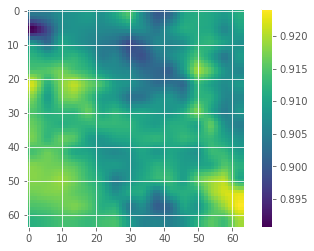

In [ ]:
plt.imshow(x_train[500,0,:,:])
plt.colorbar()

array([[308.88000488, 308.98001099, 308.8999939 , ..., 306.73999023,
        306.54000854, 307.07998657],
       [308.83999634, 309.38000488, 309.51998901, ..., 307.01998901,
        306.92001343, 307.29998779],
       [308.6000061 , 309.22000122, 309.6000061 , ..., 307.27999878,
        307.42001343, 307.77999878],
       ...,
       [310.94000244, 312.94000244, 313.57998657, ..., 310.70001221,
        309.77999878, 309.94000244],
       [311.07998657, 312.6000061 , 313.07998657, ..., 312.20001221,
        311.22000122, 310.95999146],
       [309.20001221, 311.48001099, 313.01998901, ..., 313.44000244,
        312.83999634, 312.70001221]])

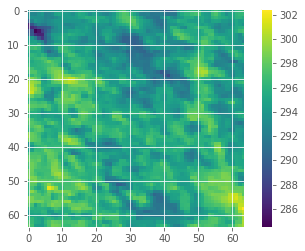

In [ ]:
plt.imshow(y_train[500,0,:,:])
plt.colorbar()


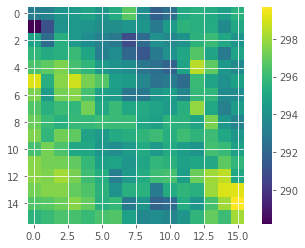

In [ ]:
a = downsampling(y_train[500,0,:,:], scale)
plt.imshow(a)
plt.colorbar()

In [ ]:
# THE DATASET CLASS
class LOADDataset(Dataset):
    def __init__(self, image_data, labels):
        self.image_data = image_data
        self.labels = labels
    def __len__(self):
        return (len(self.image_data))
    def __getitem__(self, index):
        image = self.image_data[index]
        label = self.labels[index]
        return (
            torch.tensor(image, dtype=torch.float),
            torch.tensor(label, dtype=torch.float)
        )

In [ ]:
# train and validation data
train_data = LOADDataset(x_train, y_train)
val_data = LOADDataset(x_val, y_val)
# train and validation loaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle = True)
val_loader = DataLoader(val_data, batch_size=batch_size)

In [ ]:
# initialize the model
print('Computation device: ', device)
model = UNet(bilinear=0).to(device)
# print(model)

Computation device:  cuda


In [ ]:
# THIS CELL CONTAINS FUNCTIONS FOR COMPUTING GRADIENT
def gradient_compute(img):
    # THE SIMPLEST WAY TO CALCULATE GRADIENT
    grad_x = torch.zeros(img.shape)
    grad_y = torch.zeros(img.shape)
    grad_x[:,:,:,:-1] = (img[:, :, :, :-1] - img[:, :, :, 1:])
    grad_y[:,:,:-1,:] = (img[:, :, :-1, :] - img[:, :, 1:, :])

    return torch.sqrt(grad_x**2 + grad_y**2 + 1e-20)

def compute_grad(img):
    # A MORE COMPLEX WAY TO CALCULATE GRADIENT
    kernel_v = [[0, -1, 0], 
                [0, 0, 0], 
                [0, 1, 0]]
    kernel_h = [[0, 0, 0], 
                [-1, 0, 1], 
                [0, 0, 0]]
    kernel_h = torch.FloatTensor(kernel_h).unsqueeze(0).unsqueeze(0)
    kernel_v = torch.FloatTensor(kernel_v).unsqueeze(0).unsqueeze(0)
    weight_h = nn.Parameter(data = kernel_h, requires_grad = False).cuda()
    weight_v = nn.Parameter(data = kernel_v, requires_grad = False).cuda()

    x0_v = F.conv2d(img, weight_v, padding=2)
    x0_h = F.conv2d(img, weight_h, padding=2)
    x0 = torch.sqrt(torch.pow(x0_v, 2) + torch.pow(x0_h, 2)+1e-20)
    return x0

def get_grad_loss(disp, img):
    # THE FINAL LOSS FUNCTION
    mse_img = ((disp - img)**2).mean()
    mse_grad = ((compute_grad(img) - compute_grad(disp))**2).mean()
    return mse_img*0.7 + 0.3*mse_grad

# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr/250)
# loss function 
# criterion = nn.MSELoss()

In [ ]:
def psnr(label, outputs, max_val=max_val):
    """
    Compute Peak Signal to Noise Ratio (the higher the better).
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE).
    https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio#Definition
    First we need to convert torch tensors to NumPy operable.
    """
    label = label.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()*max_val
    img_diff = outputs - label
    rmse = math.sqrt(np.mean((img_diff) ** 2))
    if rmse == 0:
        return 100
    else:
        PSNR = 20 * math.log10(np.max(label) / rmse)
        return PSNR

In [ ]:
def ssim(label, outputs):

    label = label.cpu().detach().numpy().reshape(label.shape[0], label.shape[2], label.shape[3])
    outputs = outputs.cpu().detach().numpy().reshape(outputs.shape[0], outputs.shape[2], outputs.shape[3])
    outputs *= max_val

    ssim_maps = []
    for labe, out in zip(label, outputs):
      C1 = (0.01 * np.max(labe))**2
      C2 = (0.03 * np.max(labe))**2

      img1 = labe.astype(np.float64)
      img2 = out.astype(np.float64)
      kernel = cv2.getGaussianKernel(11, 1.5)
      window = np.outer(kernel, kernel.transpose())

      mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
      mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
      mu1_sq = mu1**2
      mu2_sq = mu2**2
      mu1_mu2 = mu1 * mu2
      sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
      sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
      sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

      ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
      ssim_maps.append(ssim_map)
    return np.array(ssim_map).mean()

In [ ]:
def train(model, dataloader):
    model.train()
    running_loss = 0.0
    running_psnr = 0.0
    running_ssim = 0.0
    for bi, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        image_data = data[0].to(device)
        label = data[1].to(device)
        
        # zero grad the optimizer
        optimizer.zero_grad()
        outputs = model(image_data)
        # print(outputs.shape)
        # print(outputs.shape, label.shape)
        loss = get_grad_loss(outputs*max_val, label)
        # backpropagation
        loss.backward()
        # update the parameters
        optimizer.step()
        # add loss of each item (total items in a batch = batch size)
        running_loss += loss.item()
        # calculate batch psnr (once every `batch_size` iterations)
        batch_psnr =  psnr(label, outputs)
        running_psnr += batch_psnr
        batch_ssim =  ssim(label, outputs)
        running_ssim += batch_ssim
    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/int(len(train_data)/dataloader.batch_size)
    final_ssim = running_ssim/int(len(train_data)/dataloader.batch_size)
    return final_loss, final_psnr, final_ssim

In [ ]:
def validate(model, dataloader, epoch):
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0
    running_ssim = 0.0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            image_data = data[0].to(device)
            label = data[1].to(device)
            outputs = model(image_data)
            
            loss = get_grad_loss(outputs*max_val, label)
            # add loss of each item (total items in a batch = batch size) 
            running_loss += loss.item()
            # calculate batch psnr (once every `batch_size` iterations)
            batch_psnr = psnr(label, outputs)
            running_psnr += batch_psnr
            batch_ssim =  ssim(label, outputs)
            running_ssim += batch_ssim
        outputs = outputs.cpu()
        # save_image(outputs, f"../outputs/val_sr{epoch}.png")
    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/int(len(val_data)/dataloader.batch_size)
    final_ssim = running_ssim/int(len(val_data)/dataloader.batch_size)
    return final_loss, final_psnr, final_ssim

In [ ]:
# TRAINING CELL
train_loss, val_loss = [], []
train_psnr, val_psnr = [], []
train_ssim, val_ssim = [], []
start = time.time()
vloss = np.inf
for epoch in range(epochs):
    print(f"Epoch {epoch + 1} of {epochs}")
    train_epoch_loss, train_epoch_psnr, train_epoch_ssim = train(model, train_loader)
    val_epoch_loss, val_epoch_psnr, val_epoch_ssim = validate(model, val_loader, epoch)
    # print(f"Train PSNR: {train_epoch_psnr:.3f}")
    # print(f"Val PSNR: {val_epoch_psnr:.3f}")
    # print(f"Train SSIM: {train_epoch_ssim:.3f}")
    # print(f"Val SSIM: {val_epoch_ssim:.3f}")
    print(f"Train loss: {train_epoch_loss:.6f}")
    print(f"Val loss: {val_epoch_loss:.6f}")
    train_loss.append(train_epoch_loss)
    train_psnr.append(train_epoch_psnr)
    train_ssim.append(train_epoch_ssim)
    val_loss.append(val_epoch_loss)
    val_psnr.append(val_epoch_psnr)
    val_ssim.append(val_epoch_ssim)
    if val_epoch_loss < vloss:
      print("Save model...")
      torch.save(model.state_dict(), 'modelUnetx4_batch_skip_cv2_zerocloud_skip_gradmse2.pth')
      vloss = val_epoch_loss
end = time.time()
print(f"Finished training in: {((end-start)/60):.3f} minutes")

Epoch 1 of 300


1429it [01:40, 14.27it/s]                          
239it [00:07, 31.29it/s]                         


Train loss: 0.102408
Val loss: 0.095169
Save model...
Epoch 2 of 300


1429it [01:40, 14.27it/s]                          
239it [00:07, 31.24it/s]                         


Train loss: 0.098232
Val loss: 0.091066
Save model...
Epoch 3 of 300


1429it [01:40, 14.27it/s]                          
239it [00:07, 31.07it/s]


Train loss: 0.095553
Val loss: 0.087634
Save model...
Epoch 4 of 300


1429it [01:40, 14.27it/s]                          
239it [00:07, 31.22it/s]                         


Train loss: 0.093808
Val loss: 0.085669
Save model...
Epoch 5 of 300


1429it [01:40, 14.27it/s]                          
239it [00:07, 31.31it/s]                         


Train loss: 0.092182
Val loss: 0.089265
Epoch 6 of 300


1429it [01:40, 14.28it/s]                          
239it [00:07, 31.24it/s]                         


Train loss: 0.090443
Val loss: 0.088508
Epoch 7 of 300


1429it [01:40, 14.28it/s]                          
239it [00:07, 31.37it/s]                         


Train loss: 0.089047
Val loss: 0.083431
Save model...
Epoch 8 of 300


1429it [01:40, 14.27it/s]                          
239it [00:07, 31.30it/s]


Train loss: 0.088043
Val loss: 0.083423
Save model...
Epoch 9 of 300


1429it [01:40, 14.26it/s]                          
239it [00:07, 31.18it/s]                         


Train loss: 0.087119
Val loss: 0.084463
Epoch 10 of 300


1429it [01:40, 14.27it/s]                          
239it [00:07, 31.15it/s]                         


Train loss: 0.085936
Val loss: 0.081950
Save model...
Epoch 11 of 300


1429it [01:40, 14.26it/s]                          
239it [00:07, 31.40it/s]                         


Train loss: 0.085399
Val loss: 0.082797
Epoch 12 of 300


1429it [01:40, 14.27it/s]                          
239it [00:07, 31.21it/s]                         


Train loss: 0.084722
Val loss: 0.079836
Save model...
Epoch 13 of 300


1429it [01:40, 14.25it/s]                          
239it [00:07, 31.24it/s]                         


Train loss: 0.084074
Val loss: 0.078650
Save model...
Epoch 14 of 300


1429it [01:40, 14.26it/s]                          
239it [00:07, 31.32it/s]                         


Train loss: 0.083415
Val loss: 0.080180
Epoch 15 of 300


1429it [01:40, 14.27it/s]                          
239it [00:07, 31.10it/s]                         


Train loss: 0.082723
Val loss: 0.079556
Epoch 16 of 300


1429it [01:40, 14.28it/s]                          
239it [00:07, 31.16it/s]                         


Train loss: 0.082416
Val loss: 0.080207
Epoch 17 of 300


1429it [01:40, 14.27it/s]                          
239it [00:07, 31.36it/s]                         


Train loss: 0.081816
Val loss: 0.078860
Epoch 18 of 300


1429it [01:40, 14.26it/s]                          
239it [00:07, 31.12it/s]                         


Train loss: 0.081213
Val loss: 0.079444
Epoch 19 of 300


1429it [01:40, 14.26it/s]                          
239it [00:07, 31.25it/s]                         


Train loss: 0.080552
Val loss: 0.077257
Save model...
Epoch 20 of 300


1429it [01:40, 14.22it/s]                          
239it [00:07, 31.12it/s]                         


Train loss: 0.080411
Val loss: 0.078342
Epoch 21 of 300


1429it [01:40, 14.25it/s]                          
239it [00:07, 31.15it/s]                         


Train loss: 0.079966
Val loss: 0.082547
Epoch 22 of 300


1429it [01:40, 14.26it/s]                          
239it [00:07, 31.33it/s]                         


Train loss: 0.079519
Val loss: 0.076142
Save model...
Epoch 23 of 300


1429it [01:40, 14.25it/s]                          
239it [00:07, 31.10it/s]                         


Train loss: 0.079032
Val loss: 0.078643
Epoch 24 of 300


1429it [01:40, 14.24it/s]                          
239it [00:07, 30.93it/s]                         


Train loss: 0.078653
Val loss: 0.078007
Epoch 25 of 300


1429it [01:40, 14.27it/s]                          
239it [00:07, 30.94it/s]                         


Train loss: 0.078218
Val loss: 0.076026
Save model...
Epoch 26 of 300


1429it [01:40, 14.26it/s]                          
239it [00:07, 31.18it/s]                         


Train loss: 0.077816
Val loss: 0.073830
Save model...
Epoch 27 of 300


1429it [01:40, 14.26it/s]                          
239it [00:07, 31.08it/s]                         


Train loss: 0.077381
Val loss: 0.079739
Epoch 28 of 300


1429it [01:40, 14.27it/s]                          
239it [00:07, 31.13it/s]                         


Train loss: 0.076906
Val loss: 0.075394
Epoch 29 of 300


1429it [01:40, 14.27it/s]                          
239it [00:07, 31.16it/s]                         


Train loss: 0.076410
Val loss: 0.075043
Epoch 30 of 300


1429it [01:40, 14.25it/s]                          
239it [00:07, 31.15it/s]                         


Train loss: 0.075822
Val loss: 0.073183
Save model...
Epoch 31 of 300


1429it [01:40, 14.24it/s]                          
239it [00:07, 31.23it/s]                         


Train loss: 0.075318
Val loss: 0.072458
Save model...
Epoch 32 of 300


1429it [01:40, 14.24it/s]                          
239it [00:07, 31.21it/s]                         


Train loss: 0.074727
Val loss: 0.074222
Epoch 33 of 300


1429it [01:40, 14.28it/s]                          
239it [00:07, 30.97it/s]                         


Train loss: 0.074132
Val loss: 0.072348
Save model...
Epoch 34 of 300


1429it [01:40, 14.26it/s]                          
239it [00:07, 30.93it/s]


Train loss: 0.073187
Val loss: 0.071723
Save model...
Epoch 35 of 300


1429it [01:40, 14.24it/s]                          
239it [00:07, 31.11it/s]                         


Train loss: 0.072584
Val loss: 0.069774
Save model...
Epoch 36 of 300


1429it [01:40, 14.26it/s]                          
239it [00:07, 31.07it/s]                         


Train loss: 0.071619
Val loss: 0.069392
Save model...
Epoch 37 of 300


1429it [01:40, 14.24it/s]                          
239it [00:07, 31.05it/s]                         


Train loss: 0.070872
Val loss: 0.068390
Save model...
Epoch 38 of 300


1429it [01:40, 14.23it/s]                          
239it [00:07, 31.20it/s]                         


Train loss: 0.069718
Val loss: 0.067212
Save model...
Epoch 39 of 300


1429it [01:40, 14.17it/s]                          
239it [00:07, 31.08it/s]                         


Train loss: 0.068678
Val loss: 0.066765
Save model...
Epoch 40 of 300


1429it [01:40, 14.26it/s]                          
239it [00:07, 31.05it/s]                         


Train loss: 0.067557
Val loss: 0.065501
Save model...
Epoch 41 of 300


1429it [01:40, 14.25it/s]                          
239it [00:07, 31.09it/s]                         


Train loss: 0.066374
Val loss: 0.065278
Save model...
Epoch 42 of 300


1429it [01:40, 14.24it/s]                          
239it [00:07, 30.95it/s]                         


Train loss: 0.065171
Val loss: 0.064046
Save model...
Epoch 43 of 300


1429it [01:40, 14.22it/s]                          
239it [00:07, 31.21it/s]                         


Train loss: 0.063977
Val loss: 0.063470
Save model...
Epoch 44 of 300


1429it [01:40, 14.21it/s]                          
239it [00:07, 31.11it/s]                         


Train loss: 0.062686
Val loss: 0.062786
Save model...
Epoch 45 of 300


1429it [01:40, 14.23it/s]                          
239it [00:07, 31.12it/s]                         


Train loss: 0.061618
Val loss: 0.064800
Epoch 46 of 300


1429it [01:40, 14.24it/s]                          
239it [00:07, 31.18it/s]                         


Train loss: 0.060461
Val loss: 0.061544
Save model...
Epoch 47 of 300


1429it [01:40, 14.23it/s]                          
239it [00:07, 31.31it/s]                         


Train loss: 0.059417
Val loss: 0.061225
Save model...
Epoch 48 of 300


1429it [01:40, 14.27it/s]                          
239it [00:07, 31.28it/s]                         


Train loss: 0.058218
Val loss: 0.057972
Save model...
Epoch 49 of 300


1429it [01:40, 14.27it/s]                          
239it [00:07, 31.16it/s]                         


Train loss: 0.057290
Val loss: 0.058323
Epoch 50 of 300


1429it [01:40, 14.28it/s]                          
239it [00:07, 31.25it/s]                         


Train loss: 0.056216
Val loss: 0.056984
Save model...
Epoch 51 of 300


1429it [01:40, 14.27it/s]                          
239it [00:07, 31.17it/s]                         


Train loss: 0.055121
Val loss: 0.059216
Epoch 52 of 300


1429it [01:40, 14.28it/s]                          
239it [00:07, 31.34it/s]                         


Train loss: 0.054283
Val loss: 0.055753
Save model...
Epoch 53 of 300


1429it [01:40, 14.27it/s]                          
239it [00:07, 31.11it/s]                         


Train loss: 0.053506
Val loss: 0.055838
Epoch 54 of 300


1429it [01:40, 14.28it/s]                          
239it [00:07, 31.19it/s]                         


Train loss: 0.052506
Val loss: 0.053107
Save model...
Epoch 55 of 300


1429it [01:40, 14.27it/s]                          
239it [00:07, 31.07it/s]                         


Train loss: 0.051736
Val loss: 0.052375
Save model...
Epoch 56 of 300


1429it [01:40, 14.26it/s]                          
239it [00:07, 31.30it/s]                         


Train loss: 0.050978
Val loss: 0.051577
Save model...
Epoch 57 of 300


1429it [01:40, 14.26it/s]                          
239it [00:07, 31.07it/s]                         


Train loss: 0.050272
Val loss: 0.051772
Epoch 58 of 300


1429it [01:40, 14.28it/s]                          
239it [00:07, 31.25it/s]                         


Train loss: 0.049531
Val loss: 0.051200
Save model...
Epoch 59 of 300


1429it [01:40, 14.24it/s]                          
239it [00:07, 31.00it/s]                         


Train loss: 0.048892
Val loss: 0.052270
Epoch 60 of 300


1429it [01:40, 14.19it/s]                          
239it [00:07, 31.05it/s]                         


Train loss: 0.047995
Val loss: 0.049778
Save model...
Epoch 61 of 300


1429it [01:40, 14.26it/s]                          
239it [00:07, 31.20it/s]                         


Train loss: 0.047604
Val loss: 0.049513
Save model...
Epoch 62 of 300


1429it [01:40, 14.25it/s]                          
239it [00:07, 31.26it/s]                         


Train loss: 0.046818
Val loss: 0.050227
Epoch 63 of 300


1429it [01:40, 14.27it/s]                          
239it [00:07, 31.21it/s]                         


Train loss: 0.046461
Val loss: 0.049997
Epoch 64 of 300


1429it [01:40, 14.25it/s]                          
239it [00:07, 31.10it/s]                         


Train loss: 0.045658
Val loss: 0.048856
Save model...
Epoch 65 of 300


1429it [01:40, 14.26it/s]                          
239it [00:07, 31.33it/s]                         


Train loss: 0.045215
Val loss: 0.048677
Save model...
Epoch 66 of 300


1429it [01:40, 14.25it/s]                          
239it [00:07, 31.32it/s]                         


Train loss: 0.044498
Val loss: 0.047681
Save model...
Epoch 67 of 300


1429it [01:40, 14.27it/s]                          
239it [00:07, 31.21it/s]                         


Train loss: 0.044093
Val loss: 0.049517
Epoch 68 of 300


1429it [01:39, 14.30it/s]                          
239it [00:07, 31.25it/s]                         


Train loss: 0.043588
Val loss: 0.050118
Epoch 69 of 300


1429it [01:40, 14.28it/s]                          
239it [00:07, 31.09it/s]                         


Train loss: 0.043179
Val loss: 0.046111
Save model...
Epoch 70 of 300


1429it [01:40, 14.27it/s]                          
239it [00:07, 31.13it/s]                         


Train loss: 0.042619
Val loss: 0.045383
Save model...
Epoch 71 of 300


1429it [01:40, 14.28it/s]                          
239it [00:07, 31.15it/s]                         


Train loss: 0.041993
Val loss: 0.045820
Epoch 72 of 300


1429it [01:40, 14.29it/s]                          
239it [00:07, 31.19it/s]                         


Train loss: 0.041704
Val loss: 0.045851
Epoch 73 of 300


1429it [01:39, 14.29it/s]                          
239it [00:07, 31.17it/s]                         


Train loss: 0.041299
Val loss: 0.044788
Save model...
Epoch 74 of 300


1429it [01:40, 14.28it/s]                          
239it [00:07, 31.28it/s]                         


Train loss: 0.040790
Val loss: 0.044775
Save model...
Epoch 75 of 300


1429it [01:40, 14.27it/s]                          
239it [00:07, 31.22it/s]                         


Train loss: 0.040424
Val loss: 0.044222
Save model...
Epoch 76 of 300


1429it [01:40, 14.27it/s]                          
239it [00:07, 31.16it/s]                         


Train loss: 0.040122
Val loss: 0.045306
Epoch 77 of 300


1429it [01:40, 14.26it/s]                          
239it [00:07, 31.29it/s]                         


Train loss: 0.039499
Val loss: 0.044053
Save model...
Epoch 78 of 300


1429it [01:40, 14.26it/s]                          
239it [00:07, 30.75it/s]                         


Train loss: 0.039169
Val loss: 0.043210
Save model...
Epoch 79 of 300


1429it [01:40, 14.27it/s]                          
239it [00:07, 31.13it/s]                         


Train loss: 0.038865
Val loss: 0.042317
Save model...
Epoch 80 of 300


1429it [01:40, 14.26it/s]                          
239it [00:07, 31.06it/s]                         


Train loss: 0.038588
Val loss: 0.042921
Epoch 81 of 300


1429it [01:40, 14.28it/s]                          
239it [00:07, 31.28it/s]                         


Train loss: 0.038124
Val loss: 0.045458
Epoch 82 of 300


1429it [01:40, 14.28it/s]                          
239it [00:07, 31.15it/s]                         


Train loss: 0.037724
Val loss: 0.042401
Epoch 83 of 300


1429it [01:40, 14.27it/s]                          
239it [00:07, 31.14it/s]                         


Train loss: 0.037375
Val loss: 0.042379
Epoch 84 of 300


1429it [01:40, 14.28it/s]                          
239it [00:07, 31.32it/s]                         


Train loss: 0.036997
Val loss: 0.043103
Epoch 85 of 300


1429it [01:40, 14.28it/s]                          
239it [00:07, 31.22it/s]                         


Train loss: 0.036660
Val loss: 0.041188
Save model...
Epoch 86 of 300


1429it [01:40, 14.28it/s]                          
239it [00:07, 31.09it/s]                         


Train loss: 0.036386
Val loss: 0.042040
Epoch 87 of 300


1429it [01:39, 14.29it/s]                          
239it [00:07, 31.17it/s]                         


Train loss: 0.036083
Val loss: 0.041708
Epoch 88 of 300


1429it [01:39, 14.31it/s]                          
239it [00:07, 31.33it/s]                         


Train loss: 0.035795
Val loss: 0.041642
Epoch 89 of 300


1429it [01:39, 14.29it/s]                          
239it [00:07, 31.14it/s]                         


Train loss: 0.035426
Val loss: 0.040894
Save model...
Epoch 90 of 300


1429it [01:40, 14.29it/s]                          
239it [00:07, 31.13it/s]                         


Train loss: 0.035060
Val loss: 0.040881
Save model...
Epoch 91 of 300


1429it [01:40, 14.28it/s]                          
239it [00:07, 31.30it/s]                         


Train loss: 0.034815
Val loss: 0.040974
Epoch 92 of 300


1429it [01:40, 14.28it/s]                          
239it [00:07, 31.11it/s]                         


Train loss: 0.034435
Val loss: 0.040467
Save model...
Epoch 93 of 300


1429it [01:40, 14.27it/s]                          
239it [00:07, 31.10it/s]                         


Train loss: 0.034312
Val loss: 0.039561
Save model...
Epoch 94 of 300


1429it [01:40, 14.28it/s]                          
239it [00:07, 31.21it/s]                         


Train loss: 0.034007
Val loss: 0.040839
Epoch 95 of 300


1429it [01:40, 14.28it/s]                          
239it [00:07, 31.17it/s]                         


Train loss: 0.033716
Val loss: 0.039801
Epoch 96 of 300


1429it [01:40, 14.28it/s]                          
239it [00:07, 31.07it/s]                         


Train loss: 0.033487
Val loss: 0.040317
Epoch 97 of 300


1429it [01:40, 14.26it/s]                          
239it [00:07, 31.31it/s]                         


Train loss: 0.033258
Val loss: 0.039469
Save model...
Epoch 98 of 300


1429it [01:40, 14.26it/s]                          
239it [00:07, 31.08it/s]


Train loss: 0.032793
Val loss: 0.039340
Save model...
Epoch 99 of 300


1429it [01:40, 14.26it/s]                          
239it [00:07, 31.21it/s]                         


Train loss: 0.032601
Val loss: 0.038810
Save model...
Epoch 100 of 300


1429it [01:40, 14.25it/s]                          
239it [00:07, 30.92it/s]                         


Train loss: 0.032418
Val loss: 0.039437
Epoch 101 of 300


1429it [01:40, 14.25it/s]                          
239it [00:07, 30.86it/s]                         


Train loss: 0.032064
Val loss: 0.038259
Save model...
Epoch 102 of 300


1429it [01:40, 14.24it/s]                          
239it [00:07, 31.04it/s]                         


Train loss: 0.031855
Val loss: 0.038543
Epoch 103 of 300


1429it [01:40, 14.27it/s]                          
239it [00:07, 31.05it/s]                         


Train loss: 0.031641
Val loss: 0.038555
Epoch 104 of 300


1429it [01:40, 14.25it/s]                          
239it [00:07, 31.21it/s]                         


Train loss: 0.031423
Val loss: 0.039078
Epoch 105 of 300


1429it [01:40, 14.28it/s]                          
239it [00:07, 30.97it/s]                         


Train loss: 0.031181
Val loss: 0.039190
Epoch 106 of 300


1429it [01:40, 14.27it/s]                          
239it [00:07, 31.35it/s]                         


Train loss: 0.030938
Val loss: 0.038601
Epoch 107 of 300


1429it [01:40, 14.27it/s]                          
239it [00:07, 31.23it/s]                         


Train loss: 0.030726
Val loss: 0.039199
Epoch 108 of 300


1429it [01:40, 14.24it/s]                          
239it [00:07, 31.11it/s]                         


Train loss: 0.030566
Val loss: 0.037610
Save model...
Epoch 109 of 300


1429it [01:40, 14.24it/s]                          
239it [00:07, 30.64it/s]                         


Train loss: 0.030322
Val loss: 0.037705
Epoch 110 of 300


1429it [01:40, 14.25it/s]                          
239it [00:07, 31.12it/s]                         


Train loss: 0.030091
Val loss: 0.036884
Save model...
Epoch 111 of 300


1429it [01:40, 14.26it/s]                          
239it [00:07, 31.27it/s]                         


Train loss: 0.029804
Val loss: 0.037277
Epoch 112 of 300


1429it [01:40, 14.25it/s]                          
239it [00:07, 31.16it/s]                         


Train loss: 0.029693
Val loss: 0.037684
Epoch 113 of 300


1429it [01:40, 14.26it/s]                          
239it [00:07, 31.20it/s]                         


Train loss: 0.029458
Val loss: 0.036760
Save model...
Epoch 114 of 300


1429it [01:40, 14.26it/s]                          
239it [00:07, 31.07it/s]                         


Train loss: 0.029198
Val loss: 0.036896
Epoch 115 of 300


1429it [01:40, 14.28it/s]                          
239it [00:07, 31.05it/s]                         


Train loss: 0.029098
Val loss: 0.036322
Save model...
Epoch 116 of 300


1429it [01:40, 14.26it/s]                          
239it [00:07, 30.89it/s]                         


Train loss: 0.028799
Val loss: 0.037997
Epoch 117 of 300


1429it [01:40, 14.28it/s]                          
239it [00:07, 31.01it/s]                         


Train loss: 0.028666
Val loss: 0.036254
Save model...
Epoch 118 of 300


1429it [01:40, 14.26it/s]                          
239it [00:07, 31.10it/s]                         


Train loss: 0.028466
Val loss: 0.036841
Epoch 119 of 300


1429it [01:40, 14.28it/s]                          
239it [00:07, 31.18it/s]                         


Train loss: 0.028361
Val loss: 0.036865
Epoch 120 of 300


1429it [01:40, 14.26it/s]                          
239it [00:07, 31.24it/s]                         


Train loss: 0.028066
Val loss: 0.036135
Save model...
Epoch 121 of 300


1429it [01:40, 14.25it/s]                          
239it [00:07, 31.36it/s]                         


Train loss: 0.027933
Val loss: 0.035880
Save model...
Epoch 122 of 300


1429it [01:40, 14.24it/s]                          
239it [00:07, 31.23it/s]


Train loss: 0.027766
Val loss: 0.035661
Save model...
Epoch 123 of 300


1429it [01:40, 14.26it/s]                          
239it [00:07, 31.26it/s]                         


Train loss: 0.027629
Val loss: 0.035895
Epoch 124 of 300


1429it [01:40, 14.25it/s]                          
239it [00:07, 31.27it/s]                         


Train loss: 0.027421
Val loss: 0.036012
Epoch 125 of 300


1429it [01:40, 14.26it/s]                          
239it [00:07, 31.13it/s]                         


Train loss: 0.027335
Val loss: 0.036046
Epoch 126 of 300


1429it [01:40, 14.24it/s]                          
239it [00:07, 31.23it/s]                         


Train loss: 0.027017
Val loss: 0.036104
Epoch 127 of 300


1429it [01:40, 14.25it/s]                          
239it [00:07, 31.12it/s]


Train loss: 0.026990
Val loss: 0.035796
Epoch 128 of 300


1429it [01:40, 14.26it/s]                          
239it [00:07, 30.90it/s]                         


Train loss: 0.026794
Val loss: 0.035797
Epoch 129 of 300


1429it [01:40, 14.27it/s]                          
239it [00:07, 31.21it/s]                         


Train loss: 0.026633
Val loss: 0.035965
Epoch 130 of 300


1429it [01:40, 14.28it/s]                          
239it [00:07, 31.07it/s]                         


Train loss: 0.026468
Val loss: 0.036041
Epoch 131 of 300


1429it [01:40, 14.27it/s]                          
239it [00:07, 30.99it/s]                         


Train loss: 0.026300
Val loss: 0.034682
Save model...
Epoch 132 of 300


1429it [01:40, 14.25it/s]                          
239it [00:07, 31.18it/s]                         


Train loss: 0.026142
Val loss: 0.035534
Epoch 133 of 300


1429it [01:40, 14.25it/s]                          
239it [00:07, 31.06it/s]                         


Train loss: 0.025947
Val loss: 0.034920
Epoch 134 of 300


1429it [01:40, 14.24it/s]                          
239it [00:07, 31.06it/s]                         


Train loss: 0.025934
Val loss: 0.034835
Epoch 135 of 300


1429it [01:40, 14.23it/s]                          
239it [00:07, 31.08it/s]                         


Train loss: 0.025703
Val loss: 0.034950
Epoch 136 of 300


1429it [01:40, 14.23it/s]                          
239it [00:07, 30.95it/s]                         


Train loss: 0.025531
Val loss: 0.035485
Epoch 137 of 300


1429it [01:40, 14.25it/s]                          
239it [00:07, 31.25it/s]                         


Train loss: 0.025464
Val loss: 0.034829
Epoch 138 of 300


1429it [01:40, 14.25it/s]                          
239it [00:07, 30.94it/s]                         


Train loss: 0.025328
Val loss: 0.035009
Epoch 139 of 300


1429it [01:40, 14.24it/s]                          
239it [00:07, 30.87it/s]                         


Train loss: 0.025202
Val loss: 0.035526
Epoch 140 of 300


1429it [01:40, 14.24it/s]                          
239it [00:07, 30.91it/s]                         


Train loss: 0.025027
Val loss: 0.034186
Save model...
Epoch 141 of 300


1429it [01:40, 14.24it/s]                          
239it [00:07, 31.24it/s]                         


Train loss: 0.024851
Val loss: 0.034795
Epoch 142 of 300


1429it [01:40, 14.24it/s]                          
239it [00:07, 30.94it/s]


Train loss: 0.024850
Val loss: 0.034532
Epoch 143 of 300


1429it [01:40, 14.25it/s]                          
239it [00:07, 31.14it/s]                         


Train loss: 0.024693
Val loss: 0.034138
Save model...
Epoch 144 of 300


1429it [01:40, 14.23it/s]                          
239it [00:07, 31.27it/s]                         


Train loss: 0.024501
Val loss: 0.034218
Epoch 145 of 300


1429it [01:40, 14.24it/s]                          
239it [00:07, 31.05it/s]                         


Train loss: 0.024396
Val loss: 0.035290
Epoch 146 of 300


1429it [01:40, 14.24it/s]                          
239it [00:07, 31.03it/s]                         


Train loss: 0.024235
Val loss: 0.034025
Save model...
Epoch 147 of 300


1429it [01:40, 14.23it/s]                          
239it [00:07, 31.14it/s]


Train loss: 0.024125
Val loss: 0.034070
Epoch 148 of 300


1429it [01:40, 14.23it/s]                          
239it [00:07, 31.04it/s]                         


Train loss: 0.024050
Val loss: 0.033412
Save model...
Epoch 149 of 300


1429it [01:40, 14.23it/s]                          
239it [00:07, 31.11it/s]                         


Train loss: 0.023923
Val loss: 0.035291
Epoch 150 of 300


1429it [01:40, 14.25it/s]                          
239it [00:07, 31.24it/s]                         


Train loss: 0.023721
Val loss: 0.033895
Epoch 151 of 300


1429it [01:40, 14.25it/s]                          
239it [00:07, 31.15it/s]                         


Train loss: 0.023691
Val loss: 0.033441
Epoch 152 of 300


1429it [01:40, 14.26it/s]                          
239it [00:07, 31.05it/s]


Train loss: 0.023591
Val loss: 0.033799
Epoch 153 of 300


1429it [01:40, 14.24it/s]                          
239it [00:07, 31.16it/s]                         


Train loss: 0.023442
Val loss: 0.034200
Epoch 154 of 300


1429it [01:40, 14.24it/s]                          
239it [00:07, 30.87it/s]                         


Train loss: 0.023362
Val loss: 0.034595
Epoch 155 of 300


1429it [01:40, 14.20it/s]                          
239it [00:07, 31.03it/s]                         


Train loss: 0.023244
Val loss: 0.033703
Epoch 156 of 300


1429it [01:40, 14.23it/s]                          
239it [00:07, 31.25it/s]                         


Train loss: 0.023123
Val loss: 0.033950
Epoch 157 of 300


1429it [01:40, 14.24it/s]                          
239it [00:07, 31.04it/s]                         


Train loss: 0.023042
Val loss: 0.033511
Epoch 158 of 300


1429it [01:40, 14.23it/s]                          
239it [00:07, 30.91it/s]                         


Train loss: 0.022899
Val loss: 0.033558
Epoch 159 of 300


1429it [01:40, 14.19it/s]                          
239it [00:07, 31.23it/s]                         


Train loss: 0.022823
Val loss: 0.033321
Save model...
Epoch 160 of 300


1429it [01:40, 14.25it/s]                          
239it [00:07, 31.12it/s]                         


Train loss: 0.022672
Val loss: 0.033577
Epoch 161 of 300


1429it [01:40, 14.26it/s]                          
239it [00:07, 31.06it/s]


Train loss: 0.022564
Val loss: 0.032802
Save model...
Epoch 162 of 300


1429it [01:40, 14.26it/s]                          
239it [00:07, 31.26it/s]                         


Train loss: 0.022473
Val loss: 0.033492
Epoch 163 of 300


1429it [01:40, 14.26it/s]                          
239it [00:07, 30.86it/s]                         


Train loss: 0.022385
Val loss: 0.032998
Epoch 164 of 300


1429it [01:40, 14.27it/s]                          
239it [00:07, 30.87it/s]                         


Train loss: 0.022370
Val loss: 0.032788
Save model...
Epoch 165 of 300


1429it [01:40, 14.27it/s]                          
239it [00:07, 31.09it/s]                         


Train loss: 0.022214
Val loss: 0.033359
Epoch 166 of 300


1429it [01:39, 14.29it/s]                          
239it [00:07, 31.29it/s]                         


Train loss: 0.022155
Val loss: 0.033092
Epoch 167 of 300


1429it [01:40, 14.27it/s]                          
239it [00:07, 31.06it/s]                         


Train loss: 0.022036
Val loss: 0.032417
Save model...
Epoch 168 of 300


1429it [01:40, 14.16it/s]                          
239it [00:07, 30.86it/s]                         


Train loss: 0.021998
Val loss: 0.032483
Epoch 169 of 300


1429it [01:40, 14.15it/s]                          
239it [00:07, 30.96it/s]                         


Train loss: 0.021834
Val loss: 0.033222
Epoch 170 of 300


1429it [01:41, 14.11it/s]                          
239it [00:07, 30.88it/s]                         


Train loss: 0.021800
Val loss: 0.032854
Epoch 171 of 300


1429it [01:40, 14.21it/s]                          
239it [00:07, 31.08it/s]                         


Train loss: 0.021661
Val loss: 0.033864
Epoch 172 of 300


1429it [01:40, 14.20it/s]                          
239it [00:07, 31.17it/s]                         


Train loss: 0.021525
Val loss: 0.032793
Epoch 173 of 300


1429it [01:40, 14.16it/s]                          
239it [00:07, 31.11it/s]                         


Train loss: 0.021538
Val loss: 0.033056
Epoch 174 of 300


1429it [01:40, 14.23it/s]                          
239it [00:07, 31.05it/s]                         


Train loss: 0.021483
Val loss: 0.033424
Epoch 175 of 300


1429it [01:40, 14.25it/s]                          
239it [00:07, 31.11it/s]                         


Train loss: 0.021217
Val loss: 0.032222
Save model...
Epoch 176 of 300


1429it [01:41, 14.12it/s]                          
239it [00:07, 30.73it/s]


Train loss: 0.021276
Val loss: 0.032318
Epoch 177 of 300


1429it [01:40, 14.17it/s]                          
239it [00:07, 31.15it/s]                         


Train loss: 0.021116
Val loss: 0.032542
Epoch 178 of 300


1429it [01:40, 14.22it/s]                          
239it [00:07, 30.91it/s]                         


Train loss: 0.021105
Val loss: 0.032549
Epoch 179 of 300


1429it [01:40, 14.20it/s]                          
239it [00:07, 30.91it/s]                         


Train loss: 0.020947
Val loss: 0.031961
Save model...
Epoch 180 of 300


1429it [01:40, 14.15it/s]                          
239it [00:07, 30.86it/s]                         


Train loss: 0.020778
Val loss: 0.034659
Epoch 181 of 300


1429it [01:40, 14.16it/s]                          
239it [00:07, 30.78it/s]                         


Train loss: 0.020868
Val loss: 0.032387
Epoch 182 of 300


1429it [01:40, 14.15it/s]                          
239it [00:07, 30.74it/s]                         


Train loss: 0.020722
Val loss: 0.032902
Epoch 183 of 300


1429it [01:40, 14.17it/s]                          
239it [00:07, 30.80it/s]


Train loss: 0.020681
Val loss: 0.032503
Epoch 184 of 300


1429it [01:40, 14.16it/s]                          
239it [00:07, 30.91it/s]                         


Train loss: 0.020563
Val loss: 0.033429
Epoch 185 of 300


1429it [01:40, 14.16it/s]                          
239it [00:07, 30.69it/s]                         


Train loss: 0.020509
Val loss: 0.032289
Epoch 186 of 300


1429it [01:40, 14.15it/s]                          
239it [00:07, 30.94it/s]                         


Train loss: 0.020431
Val loss: 0.032941
Epoch 187 of 300


1429it [01:40, 14.16it/s]                          
239it [00:07, 30.82it/s]                         


Train loss: 0.020325
Val loss: 0.032475
Epoch 188 of 300


1429it [01:40, 14.17it/s]                          
239it [00:07, 30.75it/s]                         


Train loss: 0.020242
Val loss: 0.031979
Epoch 189 of 300


1429it [01:40, 14.17it/s]                          
239it [00:07, 30.84it/s]                         


Train loss: 0.020194
Val loss: 0.033287
Epoch 190 of 300


1429it [01:40, 14.16it/s]                          
239it [00:07, 30.75it/s]                         


Train loss: 0.020132
Val loss: 0.032585
Epoch 191 of 300


1429it [01:40, 14.18it/s]                          
239it [00:07, 30.91it/s]


Train loss: 0.020016
Val loss: 0.032863
Epoch 192 of 300


1429it [01:40, 14.17it/s]                          
239it [00:07, 30.90it/s]                         


Train loss: 0.019909
Val loss: 0.031981
Epoch 193 of 300


1429it [01:40, 14.17it/s]                          
239it [00:07, 30.86it/s]                         


Train loss: 0.019889
Val loss: 0.033456
Epoch 194 of 300


1429it [01:40, 14.16it/s]                          
239it [00:07, 30.79it/s]


Train loss: 0.019849
Val loss: 0.032409
Epoch 195 of 300


1429it [01:40, 14.16it/s]                          
239it [00:07, 30.81it/s]


Train loss: 0.019728
Val loss: 0.032753
Epoch 196 of 300


1429it [01:40, 14.16it/s]                          
239it [00:07, 30.94it/s]                         


Train loss: 0.019731
Val loss: 0.031846
Save model...
Epoch 197 of 300


1429it [01:40, 14.15it/s]                          
239it [00:07, 30.72it/s]


Train loss: 0.019581
Val loss: 0.032483
Epoch 198 of 300


1429it [01:41, 14.11it/s]                          
239it [00:07, 30.69it/s]


Train loss: 0.019573
Val loss: 0.032835
Epoch 199 of 300


1429it [01:40, 14.15it/s]                          
239it [00:07, 30.79it/s]


Train loss: 0.019558
Val loss: 0.031846
Epoch 200 of 300


1429it [01:41, 14.12it/s]                          
239it [00:07, 30.47it/s]                         


Train loss: 0.019375
Val loss: 0.031322
Save model...
Epoch 201 of 300


1429it [01:41, 14.10it/s]                          
239it [00:07, 30.43it/s]                         


Train loss: 0.019343
Val loss: 0.031813
Epoch 202 of 300


1429it [01:41, 14.05it/s]                          
239it [00:07, 30.32it/s]                         


Train loss: 0.019273
Val loss: 0.034066
Epoch 203 of 300


1429it [01:41, 14.11it/s]                          
239it [00:07, 30.38it/s]                         


Train loss: 0.019272
Val loss: 0.031514
Epoch 204 of 300


1429it [01:41, 14.07it/s]                          
239it [00:07, 30.71it/s]                         


Train loss: 0.019143
Val loss: 0.031840
Epoch 205 of 300


1429it [01:41, 14.06it/s]                          
239it [00:07, 30.20it/s]


Train loss: 0.019130
Val loss: 0.032342
Epoch 206 of 300


1429it [01:41, 14.11it/s]                          
239it [00:07, 30.71it/s]


Train loss: 0.018976
Val loss: 0.031737
Epoch 207 of 300


1429it [01:41, 14.13it/s]                          
239it [00:07, 30.46it/s]                         


Train loss: 0.018982
Val loss: 0.031745
Epoch 208 of 300


1429it [01:41, 14.06it/s]                          
239it [00:07, 30.58it/s]                         


Train loss: 0.018968
Val loss: 0.031427
Epoch 209 of 300


1429it [01:41, 14.08it/s]                          
239it [00:07, 30.61it/s]


Train loss: 0.018910
Val loss: 0.034710
Epoch 210 of 300


1429it [01:41, 14.10it/s]                          
239it [00:07, 30.90it/s]


Train loss: 0.018831
Val loss: 0.032994
Epoch 211 of 300


1429it [01:40, 14.16it/s]                          
239it [00:07, 30.65it/s]                         


Train loss: 0.018684
Val loss: 0.032523
Epoch 212 of 300


1429it [01:41, 14.12it/s]                          
239it [00:07, 30.86it/s]


Train loss: 0.018683
Val loss: 0.031571
Epoch 213 of 300


1429it [01:41, 14.11it/s]                          
239it [00:07, 30.85it/s]                         


Train loss: 0.018610
Val loss: 0.031514
Epoch 214 of 300


1429it [01:40, 14.15it/s]                          
239it [00:07, 30.85it/s]                         


Train loss: 0.018527
Val loss: 0.031682
Epoch 215 of 300


1429it [01:40, 14.15it/s]                          
239it [00:07, 30.66it/s]                         


Train loss: 0.018461
Val loss: 0.032368
Epoch 216 of 300


1429it [01:40, 14.17it/s]                          
239it [00:07, 30.84it/s]                         


Train loss: 0.018410
Val loss: 0.031714
Epoch 217 of 300


1429it [01:40, 14.17it/s]                          
239it [00:07, 30.94it/s]                         


Train loss: 0.018419
Val loss: 0.031655
Epoch 218 of 300


1429it [01:40, 14.18it/s]                          
239it [00:07, 30.64it/s]                         


Train loss: 0.018315
Val loss: 0.031146
Save model...
Epoch 219 of 300


1429it [01:40, 14.16it/s]                          
239it [00:07, 30.70it/s]                         


Train loss: 0.018254
Val loss: 0.031855
Epoch 220 of 300


1429it [01:40, 14.17it/s]                          
239it [00:07, 30.90it/s]                         


Train loss: 0.018194
Val loss: 0.031601
Epoch 221 of 300


1429it [01:40, 14.18it/s]                          
239it [00:07, 31.03it/s]                         


Train loss: 0.018114
Val loss: 0.032030
Epoch 222 of 300


1429it [01:40, 14.20it/s]                          
239it [00:07, 30.94it/s]                         


Train loss: 0.018104
Val loss: 0.032900
Epoch 223 of 300


1429it [01:40, 14.23it/s]                          
239it [00:07, 30.90it/s]                         


Train loss: 0.018061
Val loss: 0.032370
Epoch 224 of 300


1429it [01:40, 14.20it/s]                          
239it [00:07, 31.04it/s]                         


Train loss: 0.017939
Val loss: 0.031946
Epoch 225 of 300


1429it [01:40, 14.22it/s]                          
239it [00:07, 30.95it/s]                         


Train loss: 0.017961
Val loss: 0.031520
Epoch 226 of 300


1429it [01:40, 14.20it/s]                          
239it [00:07, 30.99it/s]                         


Train loss: 0.017869
Val loss: 0.031012
Save model...
Epoch 227 of 300


1429it [01:41, 14.13it/s]                          
239it [00:07, 30.63it/s]


Train loss: 0.017774
Val loss: 0.031603
Epoch 228 of 300


1429it [01:40, 14.22it/s]                          
239it [00:07, 30.84it/s]                         


Train loss: 0.017809
Val loss: 0.031470
Epoch 229 of 300


1429it [01:40, 14.21it/s]                          
239it [00:07, 30.99it/s]                         


Train loss: 0.017728
Val loss: 0.032064
Epoch 230 of 300


1429it [01:40, 14.21it/s]                          
239it [00:07, 31.08it/s]                         


Train loss: 0.017636
Val loss: 0.031356
Epoch 231 of 300


1429it [01:40, 14.22it/s]                          
239it [00:07, 31.12it/s]                         


Train loss: 0.017607
Val loss: 0.031500
Epoch 232 of 300


1429it [01:40, 14.22it/s]                          
239it [00:07, 31.14it/s]                         


Train loss: 0.017519
Val loss: 0.031108
Epoch 233 of 300


1429it [01:40, 14.22it/s]                          
239it [00:07, 31.03it/s]                         


Train loss: 0.017500
Val loss: 0.031359
Epoch 234 of 300


1429it [01:40, 14.21it/s]                          
239it [00:07, 30.88it/s]


Train loss: 0.017509
Val loss: 0.031139
Epoch 235 of 300


1429it [01:40, 14.21it/s]                          
239it [00:07, 31.07it/s]                         


Train loss: 0.017437
Val loss: 0.031154
Epoch 236 of 300


1429it [01:40, 14.21it/s]                          
239it [00:07, 30.98it/s]                         


Train loss: 0.017429
Val loss: 0.031240
Epoch 237 of 300


1429it [01:40, 14.23it/s]                          
239it [00:07, 31.02it/s]                         


Train loss: 0.017306
Val loss: 0.030654
Save model...
Epoch 238 of 300


1429it [01:40, 14.21it/s]                          
239it [00:07, 30.79it/s]                         


Train loss: 0.017273
Val loss: 0.031010
Epoch 239 of 300


1429it [01:40, 14.21it/s]                          
239it [00:07, 31.00it/s]                         


Train loss: 0.017203
Val loss: 0.030866
Epoch 240 of 300


1429it [01:40, 14.22it/s]                          
239it [00:07, 30.80it/s]                         


Train loss: 0.017275
Val loss: 0.031694
Epoch 241 of 300


1429it [01:40, 14.19it/s]                          
239it [00:07, 30.94it/s]                         


Train loss: 0.017131
Val loss: 0.031026
Epoch 242 of 300


1429it [01:40, 14.21it/s]                          
239it [00:07, 31.15it/s]


Train loss: 0.017092
Val loss: 0.031135
Epoch 243 of 300


1429it [01:40, 14.22it/s]                          
239it [00:07, 30.89it/s]                         


Train loss: 0.016996
Val loss: 0.032209
Epoch 244 of 300


1429it [01:40, 14.19it/s]                          
239it [00:07, 30.81it/s]                         


Train loss: 0.017025
Val loss: 0.032127
Epoch 245 of 300


1429it [01:41, 14.13it/s]                          
239it [00:07, 31.01it/s]                         


Train loss: 0.016943
Val loss: 0.031353
Epoch 246 of 300


1429it [01:40, 14.21it/s]                          
239it [00:07, 30.95it/s]                         


Train loss: 0.016900
Val loss: 0.031204
Epoch 247 of 300


1429it [01:40, 14.22it/s]                          
239it [00:07, 30.82it/s]                         


Train loss: 0.016830
Val loss: 0.032210
Epoch 248 of 300


1429it [01:40, 14.19it/s]                          
239it [00:07, 30.86it/s]                         


Train loss: 0.016823
Val loss: 0.031388
Epoch 249 of 300


1429it [01:40, 14.19it/s]                          
239it [00:07, 30.88it/s]                         


Train loss: 0.016781
Val loss: 0.031540
Epoch 250 of 300


1429it [01:40, 14.19it/s]                          
239it [00:07, 30.96it/s]                         


Train loss: 0.016712
Val loss: 0.031938
Epoch 251 of 300


1429it [01:40, 14.20it/s]                          
239it [00:07, 31.06it/s]


Train loss: 0.016730
Val loss: 0.032372
Epoch 252 of 300


1429it [01:40, 14.19it/s]                          
239it [00:07, 30.94it/s]                         


Train loss: 0.016564
Val loss: 0.031104
Epoch 253 of 300


 21%|██        | 295/1428 [00:20<01:19, 14.16it/s]


KeyboardInterrupt: ignored

In [ ]:
model.load_state_dict(torch.load('modelUnetx4_batch_skip_cv2_zerocloud_skip_gradmse2.pth'))
model.eval()


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [ ]:
model2 = UNet(bilinear=0).to(device)
model2.load_state_dict(torch.load('modelUnetx4_batch_skip_cv2_zerocloud.pth'))
model2.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

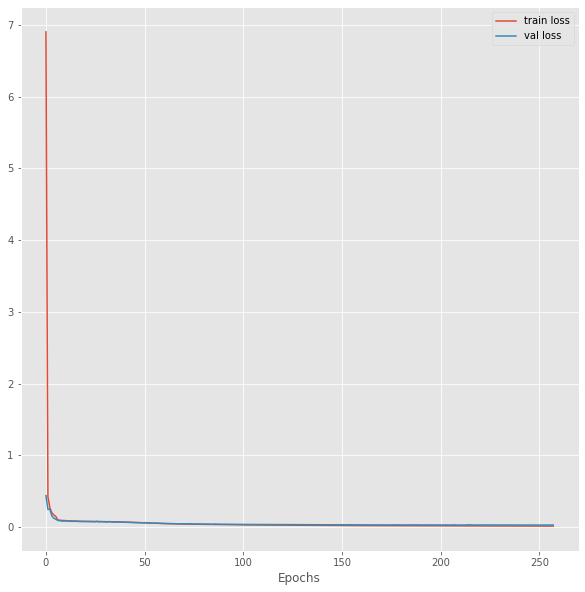

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(["train loss", "val loss"])
plt.xlabel("Epochs")
plt.savefig("Loss_modelUnetx4_batch_skip_cv2_zerocloud_skip_gradmse2.png")

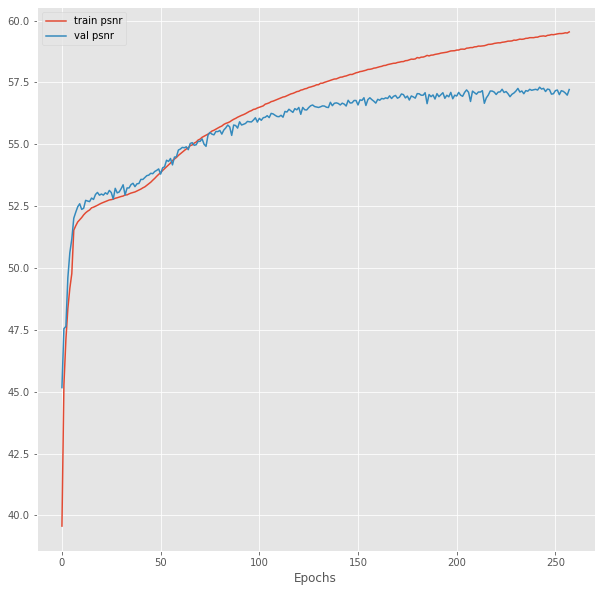

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(train_psnr)
plt.plot(val_psnr)
plt.legend(["train psnr", "val psnr"])
plt.xlabel("Epochs")
# plt.savefig("PSNR_modelUnetx4_batch_skip_cv2_zerocloud_skip_gradmse2.png")

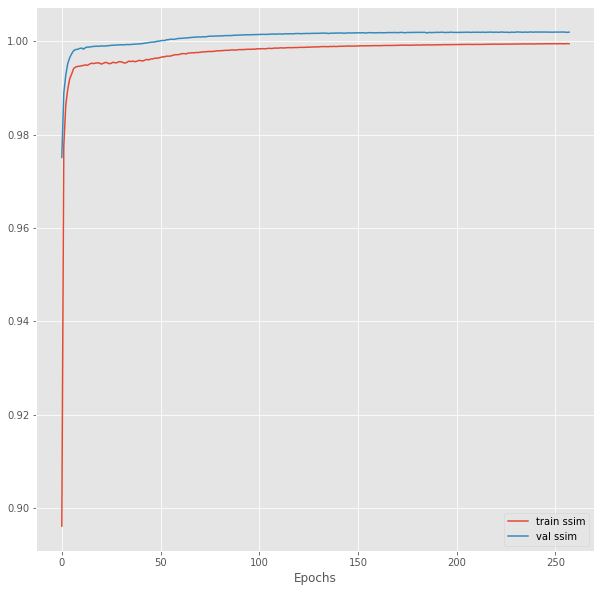

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(train_ssim)
plt.plot(val_ssim)
plt.legend(["train ssim", "val ssim"])
plt.xlabel("Epochs")
# plt.savefig("SSim_modelUnetx4_batch_skip_cv2_zerocloud_skip_gradmse2.png")

In [ ]:
def psnr_notorch(label, outputs):
    """
    Compute Peak Signal to Noise Ratio (the higher the better).
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE).
    https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio#Definition
    First we need to convert torch tensors to NumPy operable.
    """
    # label = label.cpu().detach().numpy()
    # outputs = outputs.cpu().detach().numpy()
    img_diff = outputs*max_val - label
    rmse = math.sqrt(np.mean((img_diff) ** 2))
    if rmse == 0:
        return 100
    else:
        PSNR = 20 * math.log10(np.max(label) / rmse)
        return PSNR, rmse**2

In [ ]:
# Calculate average PSNR and average MSE on n first images in val set
n = 1000
sum_PSNR_bicubic = 0
sum_mse_bicubic = 0
sum_PSNR_model = 0
sum_mse_model = 0
idx = []
for index in range(n):
  input = torch.tensor(np.reshape(x_val[index,0,:,:], (1,1,64,64)), dtype=torch.float)
  input = input.to(device)
  output = model2(input).cpu().detach().numpy()

  PSNR_bicubic, mse_bicubic = psnr_notorch(y_val[index,0,:,:], x_val[index,0,:,:])
  PSNR_model, mse_model = psnr_notorch(y_val[index,0,:,:], output[0,0,:,:])

  if mse_bicubic < mse_model:
    idx.append(index)

  sum_PSNR_bicubic += PSNR_bicubic
  sum_mse_bicubic += mse_bicubic
  sum_PSNR_model += PSNR_model
  sum_mse_model += mse_model

avg_PSNR_bicubic = sum_PSNR_bicubic/n
avg_mse_bicubic = sum_mse_bicubic/n
avg_PSNR_model = sum_PSNR_model/n
avg_mse_model = sum_mse_model/n

print("Average PSNR: Bicubic = {}, Our model = {}".format(avg_PSNR_bicubic,avg_PSNR_model))
print("Average MSE: Bicubic = {}, Our model = {}".format(avg_mse_bicubic,avg_mse_model))

Average PSNR: Bicubic = 53.850292630723956, Our model = 56.462156857586834
Average MSE: Bicubic = 0.5667894650666311, Our model = 0.23436874559559634


FROM THIS CELL, THERE ARE JUST STEPS FOR TESTING THE VISUALIZATION RESULTS AND SOME COMPARATION

In [ ]:
index = 1220

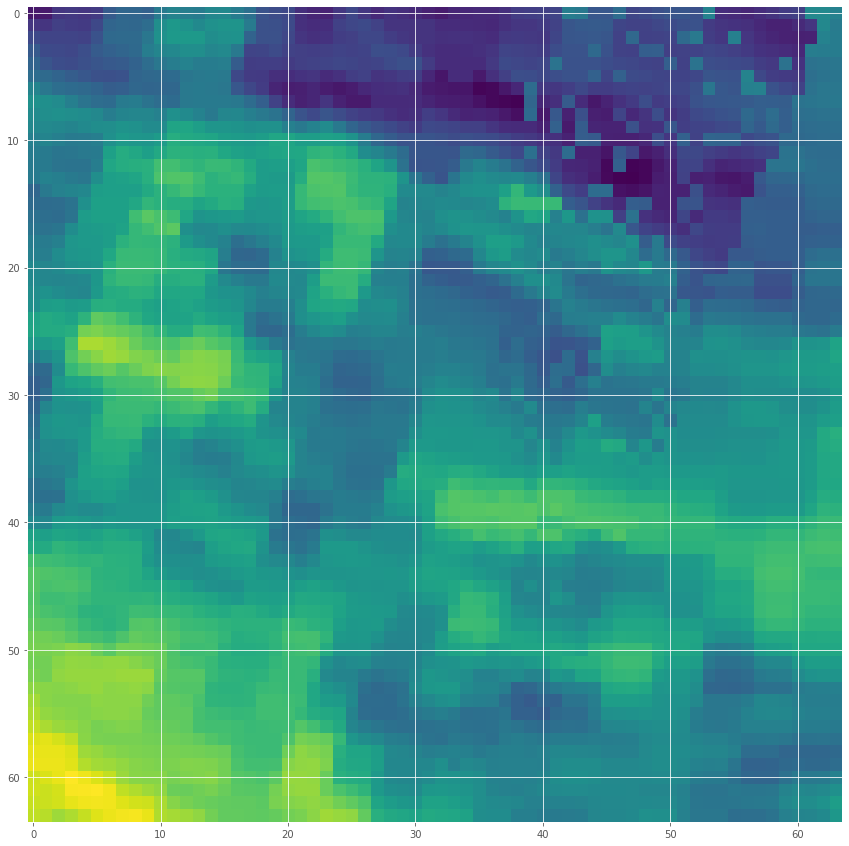

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(y_val[index,0,:,:])

In [ ]:
PSNR_bicubic, mse_bicubic = psnr_notorch(y_val[index,0,:,:], x_val[index,0,:,:])
print(PSNR_bicubic, mse_bicubic)

53.64835844649552 0.4132422875272463


In [ ]:

input = torch.tensor(np.reshape(x_val[index,0,:,:], (1,1,64,64)), dtype=torch.float)
input = input.to(device)

In [ ]:
output = model(input).cpu().detach().numpy()
output2 = model2(input).cpu().detach().numpy()

In [ ]:
PSNR_model, mse_model = psnr_notorch(y_val[index,0,:,:], output[0,0,:,:])
print(PSNR_model, mse_model)

58.50784747586957 0.1349757825321376


In [ ]:
PSNR_model2, mse_model2 = psnr_notorch(y_val[index,0,:,:], output2[0,0,:,:])
print(PSNR_model2, mse_model2)

55.99881025298335 0.24052464165811213


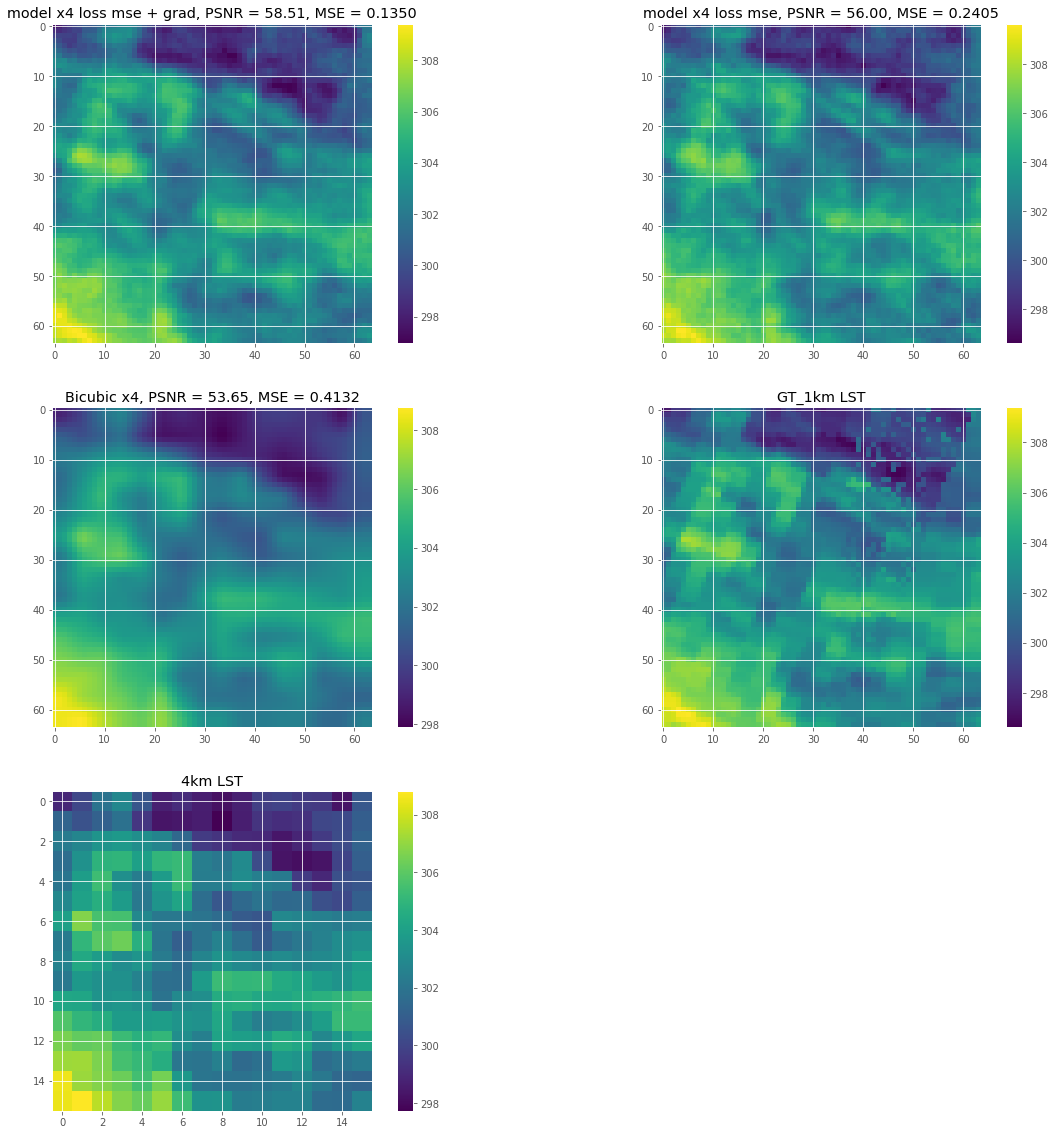

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(3,2,1)
plt.imshow(output[0,0,:,:]*max_val)
plt.title("model x4 loss mse + grad, PSNR = {:.2f}, MSE = {:.4f}".format(PSNR_model, mse_model))
plt.colorbar()
plt.subplot(3,2,2)
plt.imshow(output2[0,0,:,:]*max_val)
plt.title("model x4 loss mse, PSNR = {:.2f}, MSE = {:.4f}".format(PSNR_model2, mse_model2))
plt.colorbar()
plt.subplot(3,2,3)
plt.imshow(x_val[index,0,:,:]*max_val)
plt.title("Bicubic x4, PSNR = {:.2f}, MSE = {:.4f}".format(PSNR_bicubic, mse_bicubic))
plt.colorbar()
plt.subplot(3,2,5)
plt.imshow(downsampling(y_val[index,0,:,:], scale))
plt.title("4km LST")
plt.colorbar()
plt.subplot(3,2,4)
plt.imshow(y_val[index,0,:,:])
plt.title("GT_1km LST")
plt.colorbar()
# plt.savefig("Result_modelUnetx4_batch_skip_cv2_zerocloud_skip_gradmse2.png")

FROM THIS CELL TO THE END, THEY ARE JUST SOME OF MY TESTS, YOU DO NOT NEED TO CARE ABOUT IT FOR NOW.

In [ ]:
from glob import glob
files = glob("1km/*.tif")

In [ ]:
from osgeo import gdal
test_data = np.zeros((len(files)*2, 64, 64))
i = 0
for fn in files:
  LST_K_day,LST_K_night,cols,rows,projection,geotransform = read_tif(fn)
  test_data[i] = LST_K_day
  test_data[i+1] = LST_K_night
  i += 2

11.603808735692224 7.967956869052237


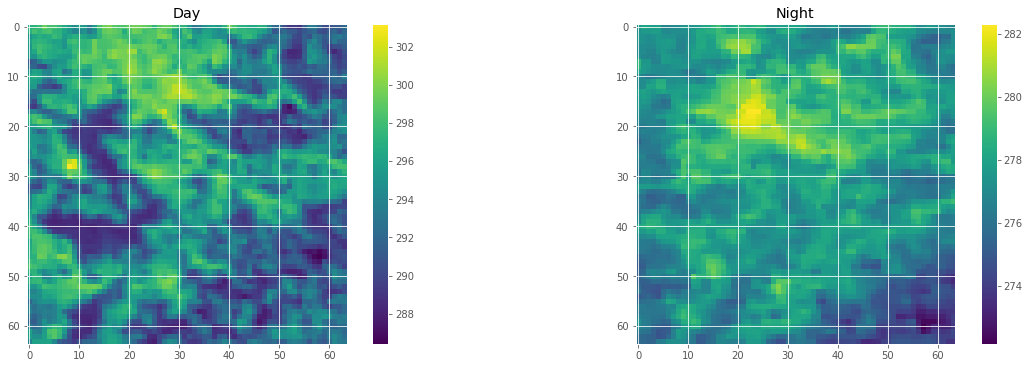

In [ ]:
i = 0
mean_day = []
mean_night = []
for l in range(len(files)):
  mean_day.append(np.max(test_data[i]) - np.min(test_data[i]))
  mean_night.append(np.max(test_data[i+1]) - np.min(test_data[i+1]))
  i += 2
print(np.mean(mean_day), np.mean(mean_night))
pair = 800
plt.figure(figsize=(20,20))
plt.subplot(3,2,1)
plt.imshow(test_data[pair])
plt.title("Day")
plt.colorbar()
plt.subplot(3,2,2)
plt.imshow(test_data[pair+1])
plt.title("Night")
plt.colorbar()


In [ ]:
test_data_new = []
ratio = 0.00
for i in range(test_data.shape[0]):
  if len(test_data[i][test_data[i] == 0]) <= ratio*test_data.shape[1]*test_data.shape[2]:
    test_data_new.append(test_data[i])
    # Y_new.append(np.flip(Y[i], 0))
    # Y_new.append(np.flip(Y[i], 1))
    # test_data_new.append(np.flip(test_data[i]))

test_data_new = np.array(test_data_new)
max_val2 = np.max(test_data_new) # BIGGEST VALUE FOR NORMALIZATION
max_val2

323.4599914550781

In [ ]:
test_data_new_down = np.zeros(test_data_new.shape)
for i in range(test_data_new.shape[0]):
  a = downsampling(test_data_new[i], 4)
  test_data_new_down[i,:,:] = upsampling(a , 4)

In [ ]:
test_data_new_down = test_data_new_down/max_val

In [ ]:
# Calculate average PSNR and average MSE on n first images in val set
n = test_data_new_down.shape[0]
sum_PSNR_bicubic = 0
sum_mse_bicubic = 0
sum_PSNR_model = 0
sum_mse_model = 0
id = []
for index in range(n):
  input = torch.tensor(np.reshape(test_data_new_down[index,:,:], (1,1,64,64)), dtype=torch.float)
  input = input.to(device)
  output = model(input).cpu().detach().numpy()

  PSNR_bicubic, mse_bicubic = psnr_notorch(test_data_new[index,:,:], test_data_new_down[index,:,:])
  PSNR_model, mse_model = psnr_notorch(test_data_new[index,:,:], output[0,0,:,:])
  if mse_bicubic < mse_model:
    id.append(index)

  sum_PSNR_bicubic += PSNR_bicubic
  sum_mse_bicubic += mse_bicubic
  sum_PSNR_model += PSNR_model
  sum_mse_model += mse_model

avg_PSNR_bicubic = sum_PSNR_bicubic/n
avg_mse_bicubic = sum_mse_bicubic/n
avg_PSNR_model = sum_PSNR_model/n
avg_mse_model = sum_mse_model/n

print("Average PSNR: Bicubic = {}, Our model = {}".format(avg_PSNR_bicubic,avg_PSNR_model))
print("Average MSE: Bicubic = {}, Our model = {}".format(avg_mse_bicubic,avg_mse_model))

Average PSNR: Bicubic = 54.40930967470811, Our model = 56.70564484471192
Average MSE: Bicubic = 0.4772843491613408, Our model = 0.21705771196465817


In [ ]:
np.shape(id)

(401,)

In [ ]:
index = id[0]

In [ ]:
PSNR_bicubic, mse_bicubic = psnr_notorch(test_data_new[index,:,:], test_data_new_down[index,:,:])
print(PSNR_bicubic, mse_bicubic)
input = torch.tensor(np.reshape(test_data_new_down[index,:,:], (1,1,64,64)), dtype=torch.float)
input = input.to(device)
output = model(input).cpu().detach().numpy()
# output2 = model2(input).cpu().detach().numpy()
PSNR_model, mse_model = psnr_notorch(test_data_new[index,:,:], output[0,0,:,:])
print(PSNR_model, mse_model)
# PSNR_model2, mse_model2 = psnr_notorch(test_data_new[index,:,:], output2[0,0,:,:])
# print(PSNR_model2, mse_model2)

62.59999602565812 0.04626744246117015
61.03022479210816 0.06641292634026284


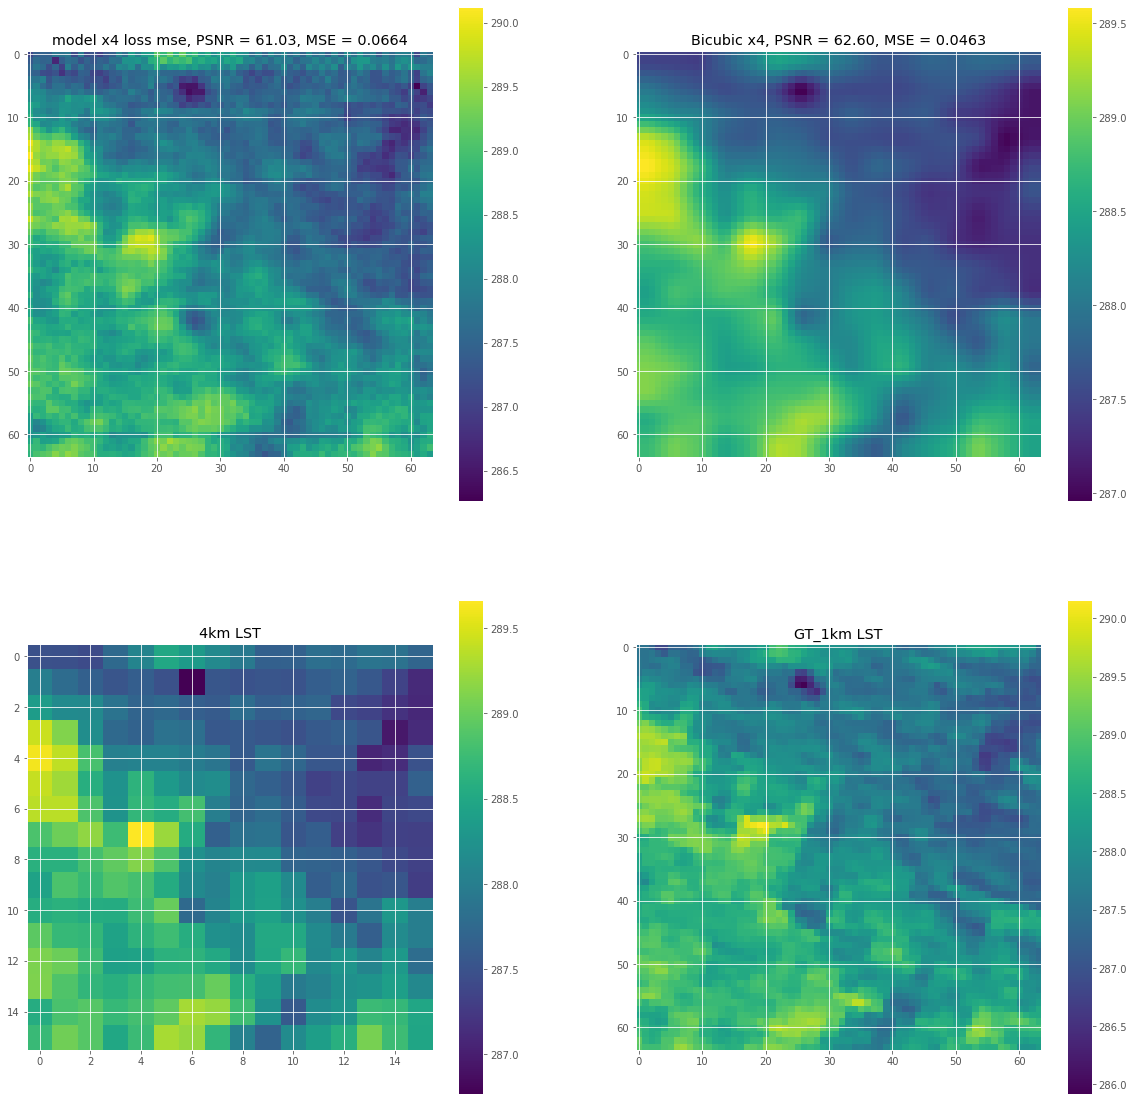

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.imshow(output[0,0,:,:]*max_val)
plt.title("model x4 loss mse, PSNR = {:.2f}, MSE = {:.4f}".format(PSNR_model, mse_model))
plt.colorbar()
# plt.subplot(3,2,2)
# plt.imshow(output2[0,0,:,:]*max_val)
# plt.title("model x2 loss mse+grad, PSNR = {:.2f}, MSE = {:.4f}".format(PSNR_model2, mse_model2))
# plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(test_data_new_down[index,:,:]*max_val)
plt.title("Bicubic x4, PSNR = {:.2f}, MSE = {:.4f}".format(PSNR_bicubic, mse_bicubic))
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(downsampling(test_data_new[index,:,:], 4))
plt.title("4km LST")
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(test_data_new[index,:,:])
plt.title("GT_1km LST")
plt.colorbar()
plt.savefig("Result_modelUnetx4_batch_skip_cv2_zerocloud.png")